# Ribosome Stalling Sites

First, create the infrastructre for the analysis.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%capture
import sys
sys.path.insert(0, '/home/raf_pc/Kemal/RiboSeqAnalysis')
from infrastructure.main import *

# Working environment
temp_repo_dir = "/home/raf_pc/Kemal/Temp"
data_repo_dir = "/home/raf_pc/Kemal/Data"

# SAM files for ribosome stalling data and coco assembly data
spt = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_TT1.sam", "60mer_TT2.sam"]]
sps = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_Rep1.sam", "60mer_Rep2.sam", "60mer_NoPK.sam"]]
coco_d = [os.path.join(data_repo_dir, "Coco", i) for i in ["Dis1.sam", "Dis2.sam"]]
coco_m = [os.path.join(data_repo_dir, "Coco", i) for i in ["Mono1.sam", "Mono2.sam"]]

# Exculude the gene below because it has over-expression problem.
exclude_genes = ["ENSG00000160789"]

# Create the infrastructure object
I = Infrastructre(temp_repo_dir, exclude_genes=exclude_genes, sixtymers=[spt, sps], coco=[coco_m, coco_d])

## Distribution of RPKM values in imported data

Let's check the relationship between two riboseq data, ideally control vs experiment pairs like sixtymers versus translatome.
<br>
Note: To draw loglog plot, zero values were removed.

In [3]:
import statsmodels.api as sm
from scipy import stats 
import seaborn as sns
from matplotlib import gridspec

def forceAspect(ax,aspect=1):
    extent =  ax.get_images().get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

def compare_two_riboseq(arr1, arr2, narr1, narr2, general=None): # translatome, sixtymers:
    # Plot the result as histograms
    fig = plt.figure(figsize=(12, 5)) 
    if general:
        fig.suptitle(general, y=1.05)
    gs = fig.add_gridspec(1, 2, width_ratios=[1.25, 1])
    axes0 = plt.subplot(gs[0])
    axes0.set_yscale('log')
    axes0.set_ylabel('Gene count')
    axes0.set_xlabel(f'RPKM')
    values = np.concatenate([arr1,arr2])
    labels = np.array([narr1] * len(arr1) + [narr2] * len(arr2))
    df_temp = pd.DataFrame.from_dict(dict(zip(["RPKM", "Label"], [values, labels])))
    sns.histplot(df_temp, x="RPKM", hue="Label", multiple="dodge", ax=axes0, bins=30)
    
    # Fit the linear line to the loglog
    non_zero = np.intersect1d(np.nonzero(arr1), np.nonzero(arr2))
    arr1_log = np.log10(arr1[non_zero])
    arr2_log = np.log10(arr2[non_zero])
    results = sm.OLS(arr2_log, sm.add_constant(arr1_log)).fit()
    x_data_log = np.linspace(arr1_log.min(), arr1_log.max(), 1000)
    y_data_log = x_data_log * results.params[1] + results.params[0]

    # Plot the result
    axes1 = plt.subplot(gs[1])
    axes1.set_xlabel(f"{narr1} RPKM (x)")
    axes1.set_ylabel(f"{narr2} RPKM (y)")
    axes1.set_xscale('log')
    axes1.set_yscale('log')
    axes1.scatter(x=arr1[non_zero], y=arr2[non_zero], marker='.', edgecolors='none')
    axes1.plot(10**x_data_log, 10**y_data_log, color="black")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
    textstr = '\n'.join((
        r'$log_{10}(y)=log_{10}(x)*%.2f + %.2f$' % (results.params[1], results.params[0]),
        r'$y=x^{%.2f}*10^{%.2f}$' % (results.params[1], results.params[0]),
        r'$R^2=%.2f$' % (results.rsquared,),
        ))
    axes1.text(0.025, 0.975, textstr, transform=axes1.transAxes, verticalalignment='top', horizontalalignment="left", bbox=props, alpha=1)
    plt.tight_layout()
    plt.show()
    
    # Check the correlation between RPKM values of translatome and experiment for sixytmer data
    corr_nonzero = stats.pearsonr(tt_rpkms[non_zero], ex_rpkms[non_zero])
    corr_all = stats.pearsonr(tt_rpkms, ex_rpkms)
    print("Pearson correlation (only nonzero): %.4f, where p=%.2f" % (corr_nonzero[0], corr_nonzero[1]))
    print("Pearson correlation (all): %.4f, where p=%.2f" % (corr_all[0], corr_all[1]))

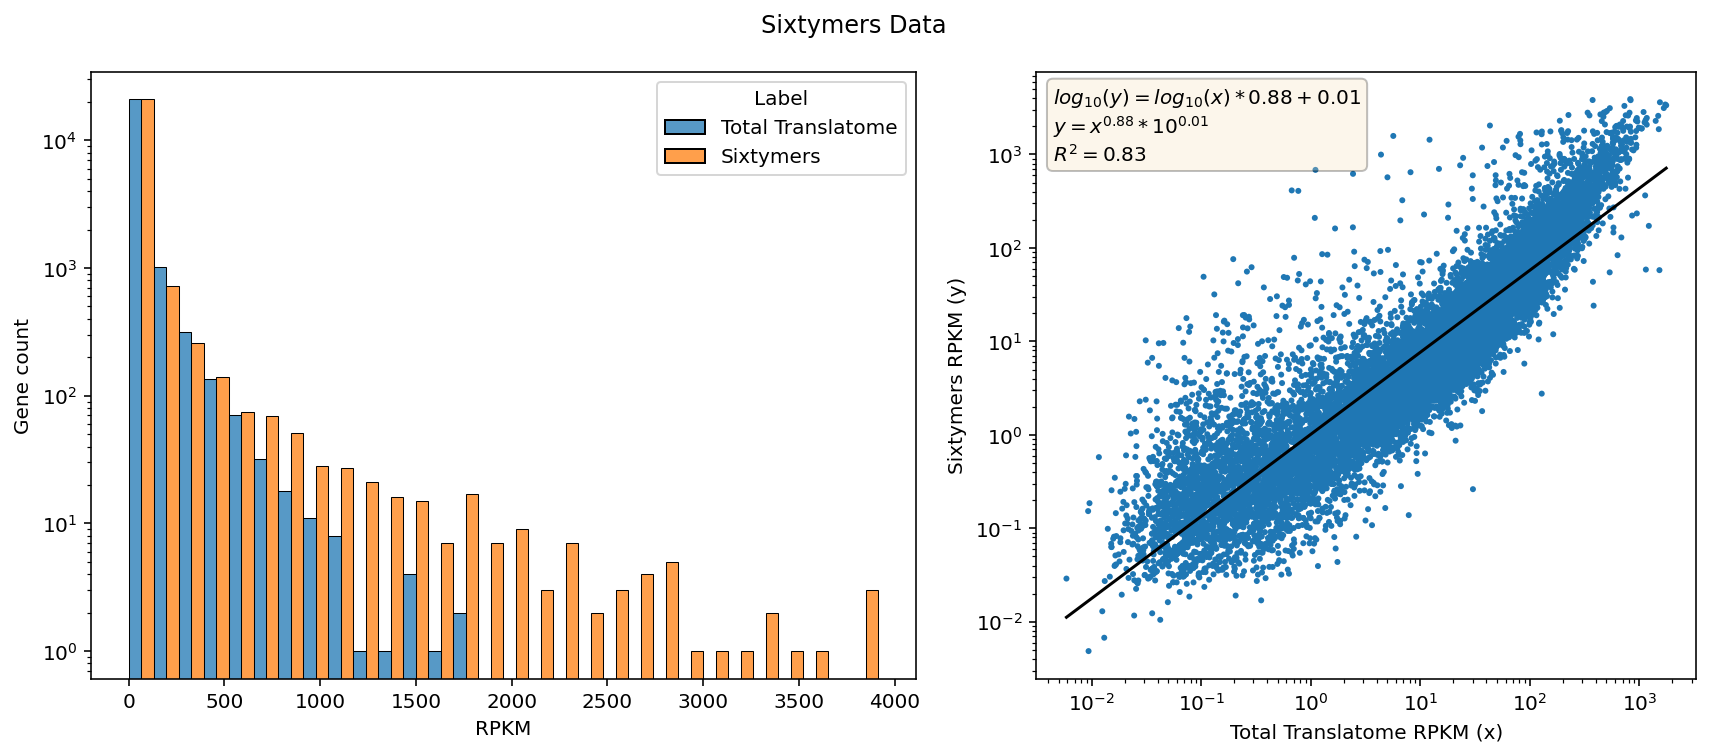

Pearson correlation (only nonzero): 0.7761, where p=0.00
Pearson correlation (all): 0.7807, where p=0.00


In [4]:
# Get the total translatome and experiment RPKM values for sixytmer data.
tt_rpkms = np.array([I.riboseq_sixtymers.translatome.calculate_rpkm_genes(g) for g in I.gene_list])
ex_rpkms = np.array([I.riboseq_sixtymers.experiment.calculate_rpkm_genes(g) for g in I.gene_list])
compare_two_riboseq(tt_rpkms, ex_rpkms, "Total Translatome", "Sixtymers", "Sixtymers Data")

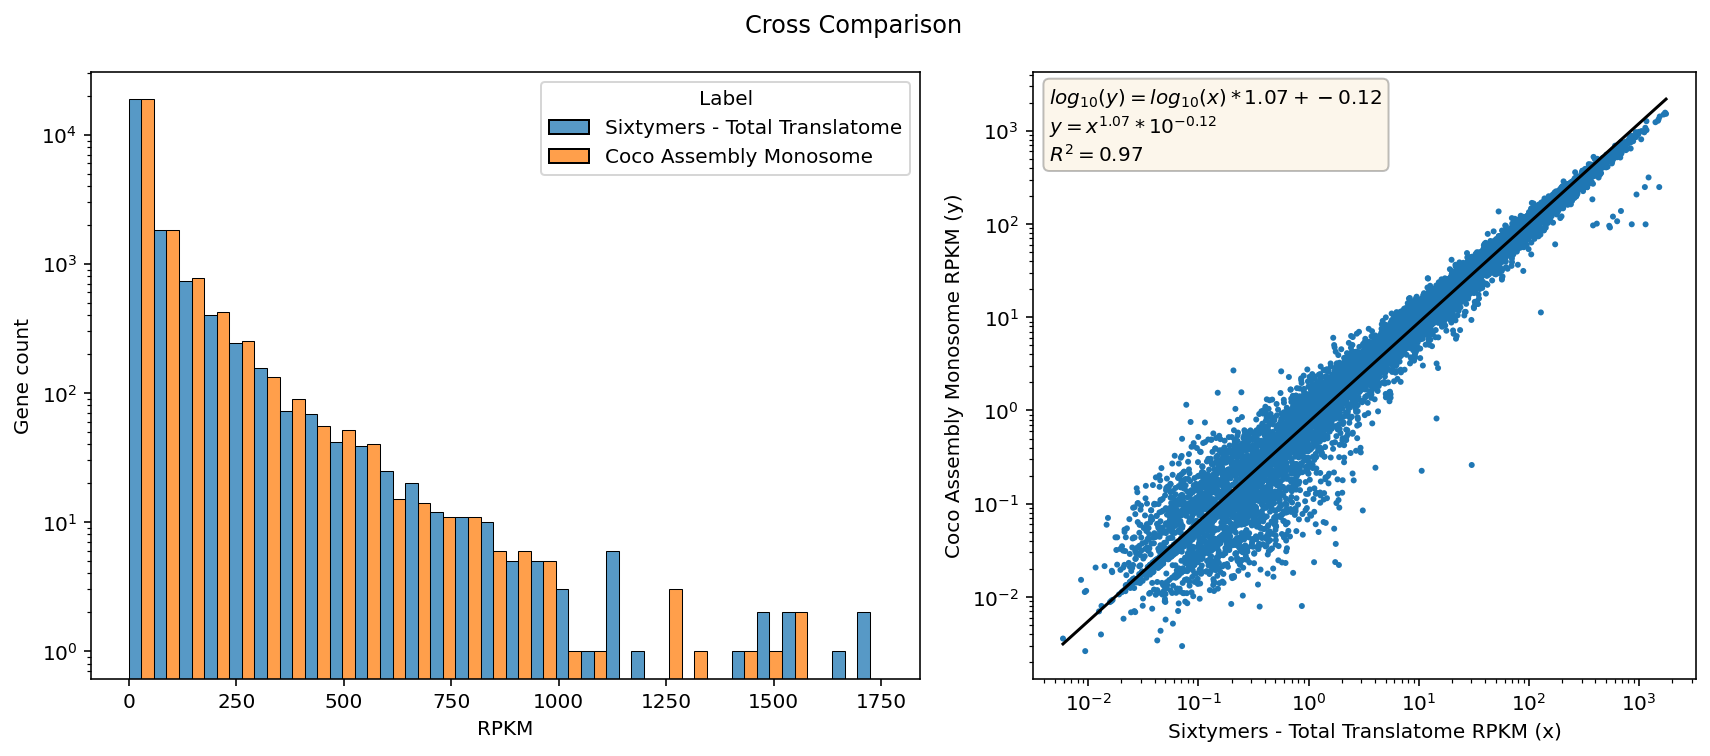

Pearson correlation (only nonzero): 0.7761, where p=0.00
Pearson correlation (all): 0.7807, where p=0.00


In [5]:
tt_si_rpkms = np.array([I.riboseq_sixtymers.translatome.calculate_rpkm_genes(g) for g in I.gene_list])
tt_co_rpkms = np.array([I.riboseq_coco.translatome.calculate_rpkm_genes(g) for g in I.gene_list])
compare_two_riboseq(tt_si_rpkms, tt_co_rpkms, "Sixtymers - Total Translatome", "Coco Assembly Monosome", "Cross Comparison")

## De-noising algorithm and its parameters

Based on the results, it is possible to say that total translatome of the sixtymers data correlates perfectly with total monosome counts of coco assembly data. This suggest that total translatome data of sixtymers represents the gene as perfectly. However, this values are for RPKM, which does not strictly mean that we will see the same phenomena in gene positions. It is possible to compare two dataset's in terms of correlation of RPM values in gene positions, but the noise in the sequencing fragment position could make the correlation work insuccessfully. For this reason, it is necessary to find out a function which denoises the arrays (RPM values from a given gene), so that the comparison will be much robust. 

In [6]:
window_types = ('flat', 'hanning', 'hamming', 'bartlett', 'blackman')
window_range = np.arange(3, 121, 2)
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_mad_msd_smoothen_window.joblib")
try:  # Because it takes very long, as written very inefficiently.
    all_mad, all_msd = joblib.load(save_metadata_path)
except FileNotFoundError:
    all_mad, all_msd = list(), list()
    for window in window_types:
        genome_response_mad, genome_response_msd = list(), list()
        for gene_id in I.gene_list:
            coco_rpkm = I.riboseq_coco.translatome.calculate_rpkm_genes(gene_id)
            sixt_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
            if coco_rpkm > 1 and sixt_rpkm > 1:
                coco_rpm_bf = I.riboseq_coco.translatome.calculate_rpm_positions(gene_id)
                sixt_rpm_bf = I.riboseq_sixtymers.translatome.calculate_rpm_positions(gene_id)
                gene_response_mad, gene_response_msd = list(), list()
                for window_len in window_range:
                    try:
                        coco_rpm = smooth_array(coco_rpm_bf, window_len=window_len, window=window)
                        sixt_rpm = smooth_array(sixt_rpm_bf, window_len=window_len, window=window)
                        c_mad = np.sum(np.abs(coco_rpm - sixt_rpm))/len(coco_rpm)  # mean absolute deviation
                        c_msd = np.sqrt(np.sum(np.power(coco_rpm - sixt_rpm, 2))/len(coco_rpm))  # mean square deviation
                    except AssertionError:
                        c_mad, c_msd = np.nan, np.nan
                    gene_response_mad.append(c_mad)
                    gene_response_msd.append(c_msd)
                genome_response_mad.append(gene_response_mad)
                genome_response_msd.append(gene_response_msd)
        all_mad.append(genome_response_mad)
        all_msd.append(genome_response_msd)
    joblib.dump((all_mad, all_msd), save_metadata_path)

Let's plot the result. I get the MAD or MSD values of all genes (which has RPKM>1 in coco translatome and sixtymer translatome) for a given window type. Then, I calculated the mean for a given window length. The curves were drawn based on the mean MAD/MSD for all genes for given window length. Elbow points were calculated by a kneed package, which is an attempt to implement the kneedle algorithm. I selected the elbow point for the optimal window length. Confidence intervals are also shown as the shaded area.

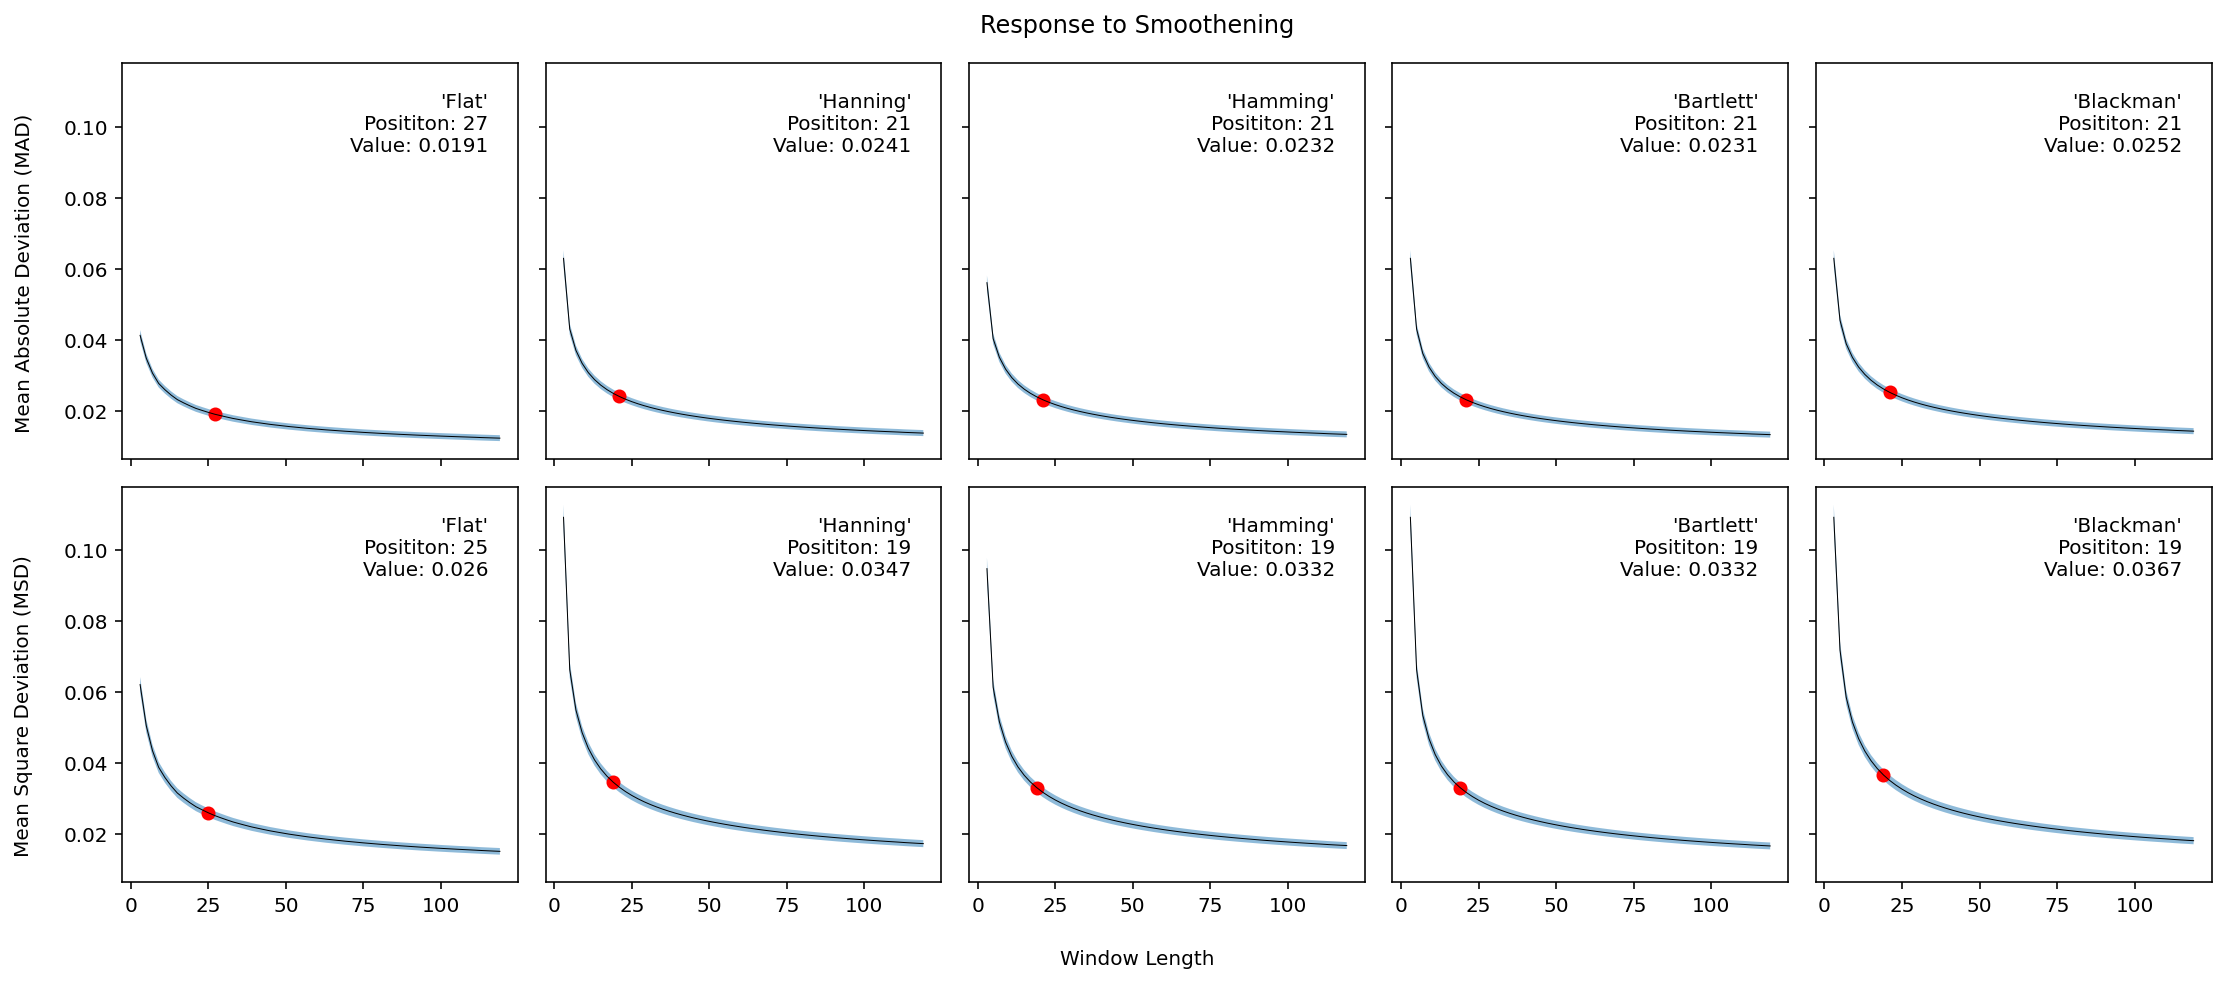

In [13]:
from kneed import KneeLocator
fig, ax = plt.subplots(2,5, figsize=(15, 6), sharex=True, sharey=True, constrained_layout=True) 
plt.suptitle("Response to Smoothening", y=1.05, )
x_data = window_range
x_labels = ["Mean Absolute Deviation (MAD)", "Mean Square Deviation (MSD)"]
CONFIDENCE = 0.999
for j, the_one in enumerate([all_mad, all_msd]):
    for k, window in enumerate(window_types):
        arr = np.array(the_one[k])
        # Statistics
        std_dev = np.nanstd(arr, axis=0)
        y_data = np.nanmean(arr, axis=0)
        se = np.array(stats.sem(arr, nan_policy='omit')) # standard error
        n = len(arr) - np.sum(np.isnan(arr), axis=0)
        ci_l, ci_h = stats.t.interval(CONFIDENCE, n-1, loc=y_data, scale=se)
        # Find elbow
        kn = KneeLocator(x_data, y_data, curve='convex', direction='decreasing')
        knee_y = y_data[list(x_data).index(kn.knee)]
        # Plot
        ax[j][k].plot(x_data, y_data, linewidth=0.5, color="black")
        ax[j][k].fill_between(x_data, ci_l, ci_h, alpha=0.5)      
        ax[j][k].scatter(kn.knee, knee_y, color="red")
        ax[j][k].text(0.925, 0.925, f"'{window.capitalize()}'\nPosititon: {kn.knee}\nValue: {round(knee_y,4)}", transform=ax[j][k].transAxes, verticalalignment='top', horizontalalignment="right", alpha=1)
fig.text(0.5, - 0.05, 'Window Length', ha='center')
fig.text(-0.02, 0.75, x_labels[0], va='center', rotation='vertical')
fig.text(-0.02, 0.25, x_labels[1], va='center', rotation='vertical')
plt.show()

Quoting from Huber, Robust Statistics, p.10, "There was a dispute between Eddington (1914, p.147) and Fisher (1920, footnote on p. 762) about the relative merits of MAD and MSD. [...] Fisher seemingly settled the matter by pointing out that for normal observations MSD is about 12% more efficient than MAD". For this reason, MSD and 'flat' window type with window length of 25. I believe this number will remove the noise while preserving the details.

## Peak Prioritization

### Smooth while preserve peaks

In [8]:
from scipy.signal import find_peaks
window_types = ('flat', 'hanning', 'hamming', 'bartlett', 'blackman')
window_range = np.arange(3, 111, 2)
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_smoothen_window_peak_detection.joblib")
try:  # Because it takes very long, as written very inefficiently.
    all_peak = joblib.load(save_metadata_path)
except FileNotFoundError:
    all_peak = list()
    for window in window_types:
        genome_response_peak = list()
        for gene_id in I.gene_list:
            exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
            tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
            if exp_rpkm > 1 and tra_rpkm > 1:
                exp_rpm_bf = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
                window_list = list()
                for window_len in window_range: 
                    try:
                        exp_rpm_s = smooth_array(exp_rpm_bf, window_len=window_len, window=window)
                        calc = len(find_peaks(exp_rpm_s)[0]) / len(exp_rpm_s) * 1000  # number of peaks detected
                    except AssertionError:
                        calc = np.nan
                    window_list.append(calc)
                genome_response_peak.append(window_list)
        all_peak.append(genome_response_peak)
    all_peak = np.array(all_peak)
    joblib.dump(all_peak, save_metadata_path)

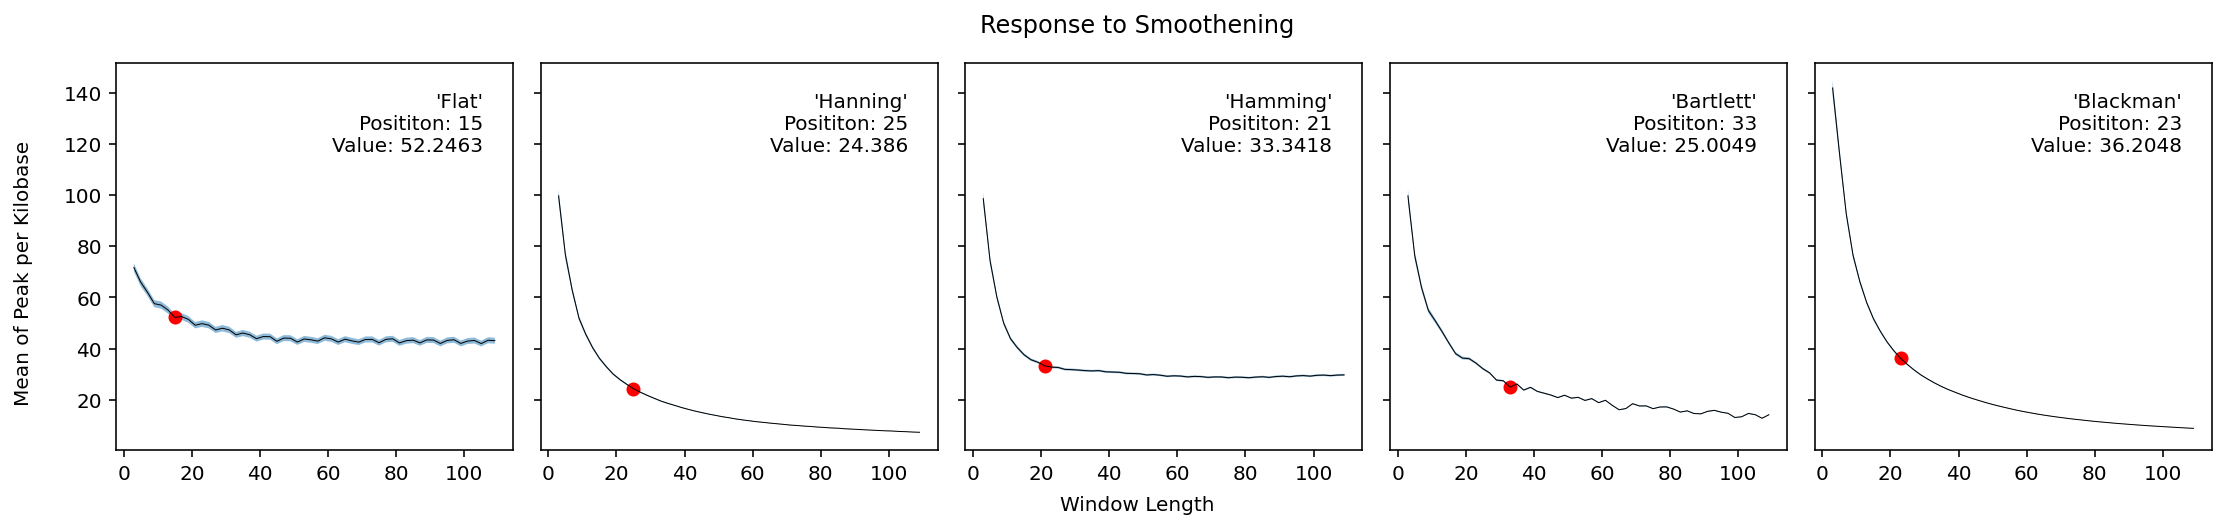

In [17]:
from kneed import KneeLocator
fig, ax = plt.subplots(1,5, figsize=(15, 3), sharex=True, sharey=True, constrained_layout=True) 
plt.suptitle("Response to Smoothening", y=1.1)
x_data = window_range
CONFIDENCE = 0.999
for k, window in enumerate(window_types):
    arr = np.array(all_peak[k])
    # Statistics
    std_dev = np.nanstd(arr, axis=0)
    y_data = np.nanmean(arr, axis=0)
    se = np.array(stats.sem(arr, nan_policy='omit')) # standard error
    n = len(arr) - np.sum(np.isnan(arr), axis=0)
    ci_l, ci_h = stats.t.interval(CONFIDENCE, n-1, loc=y_data, scale=se)
    # Find elbow
    kn = KneeLocator(x_data, y_data, curve='convex', direction='decreasing')
    knee_y = y_data[list(x_data).index(kn.knee)]
    # Plot
    ax[k].plot(x_data, y_data, linewidth=0.5, color="black")
    ax[k].fill_between(x_data, ci_l, ci_h, alpha=0.5)        
    ax[k].scatter(kn.knee, knee_y, color="red")
    ax[k].text(0.925, 0.925, f"'{window.capitalize()}'\nPosititon: {kn.knee}\nValue: {round(knee_y,4)}", transform=ax[k].transAxes, verticalalignment='top', horizontalalignment="right", alpha=1)
fig.text(0.5, - 0.05, 'Window Length', ha='center')
fig.text(-0.02, 0.5, "Mean of Peak per Kilobase", va='center', rotation='vertical')
plt.show()

This means, 'hanning' smoothing with window length 25 will be the choice. I only tried convolutional smoothing with various window types. For now, I will move forward with this one, but please note that there could be many option here, and above. Some of them are:
- Low pass Butterworth filter
- Forrier transform and get a slice
- Using other kernels like gaussian kernel
- Wiener filter, scipy filters like lfilter, Kalman filter
- tsmoothie package

### Title

In [ ]:
# GET PROMINENCES
# GET DISTRIBUTIONS OF THEM
# Based on the distribution, select a value as threshold

In [ ]:
stats.t.interval(0.95, n-1, loc=y_data, scale=se)

In [ ]:
#distribution of tt and s, peak'leri için, 

In [21]:
np.nanmean(arr, axis=0).shape

(54,)

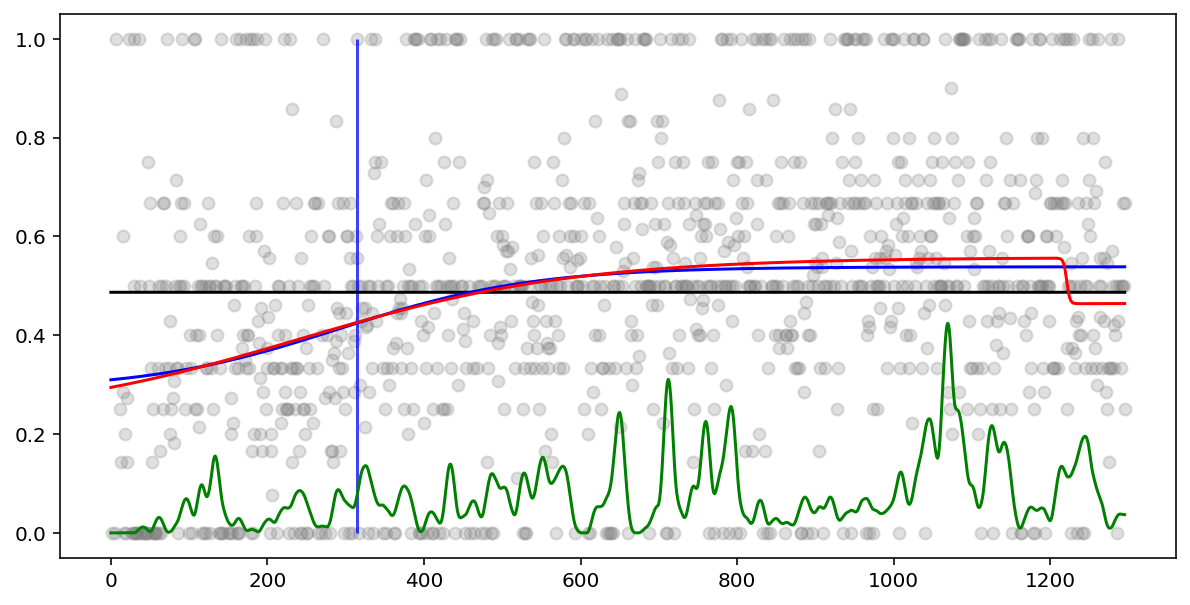

Winner: ssig
Onset: 314


76.5267095509816

In [73]:
plt.figure(figsize=(10,5))
gene_id = I.gene_list[913]
s = smooth_array(I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id), window="hanning", window_len=25)
plt.plot(s, color="green")
I.riboseq_coco.plot_result(gene_id)
I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)

In [22]:
# rpkm vs length for experiment sixtymers

In [ ]:
# update parameteres in main.py

In [ ]:
from scipy.ndimage import gaussian_filter1d

def inecik(gene_id):
    land = self.experiment.calculate_rpm_positions(gene_id)
    #land = smooth(land, window_len=15)
    land_s1=gaussian_filter1d(land, sigma=10)
    peaks = find_peaks(land_s1)[0]
    try:
        land_t = land_s1 > threshold_li(land_s1[peaks], nbins=int(len(peaks) / 3))
    except ValueError:
        land_t = []
    return land_s1, np.argwhere(land_t)

In [ ]:
plt.plot(land/land.max(), color="gray", alpha=0.5)
land_s1=gaussian_filter1d(land, sigma=15)
plt.plot(land_s1/land_s1.max(), color="blue", alpha=1)
#plt.plot(land_t, color="red", alpha=1)
plt.show()

In [ ]:
from scipy.signal.signaltools import wiener
from scipy.signal import savgol_filter, find_peaks, peak_widths


In [ ]:
# todo: a jupyter notebook aç
# - distribution of stallings
# - dist of tt
# - birbirlerine oranı'nın grafiği: correlasyon ve oranların distribution'u
# ne kadar base, ssig ve dsig var




# posizyonlar ne oranda correle oluyor: tt_stalling vs monosome
# genlerin toplam ne oranda correle oluyor: 




# tt'nin average rpkm'i kaç, bir threshold belirle, altındaki genleri disregard et

# önce fixed gaussian'la şeyap
# sonra normalize
# bütün genomdeaki bütün peak'in average genişliği ve uzunluğu kaç
# bundan significantly sapan peak'leri peak diye seç, ya da threshold belirle istatistiki olarak.
# aynısını gen içerisinde peak'leri seçerek de yap